In [1]:
import torch
import torchvision

## Device Agnostic Code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Setting up Transformer and Augmentation 

In [3]:
from torchvision import transforms

# Define the transformation pipeline
transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image with 50% probability
    transforms.ToTensor()  # Convert the image to a tensor
])

## Download the FashionMNIST Data

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = torchvision.datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform =transformer
)
test_data = torchvision.datasets.FashionMNIST(
    root='data',
    train = False,
    download = True,
    transform = transformer
)

## Getting instance of random Data(for easier Visualization)

In [5]:
import random
random_data = random.randint(0,len(train_data)-1)

images,label = train_data[random_data]
images.shape,label

(torch.Size([1, 28, 28]), 2)

## Converting to DataLoader

In [6]:
from torch.utils.data import DataLoader
import os 

Batch_size = 32

train_dataloader = DataLoader(batch_size=Batch_size,dataset = train_data,shuffle = False)
test_dataloader = DataLoader(batch_size = Batch_size,dataset = test_data,shuffle = True,)

## Getting the visulaization of the data os instance

(-0.5, 27.5, 27.5, -0.5)

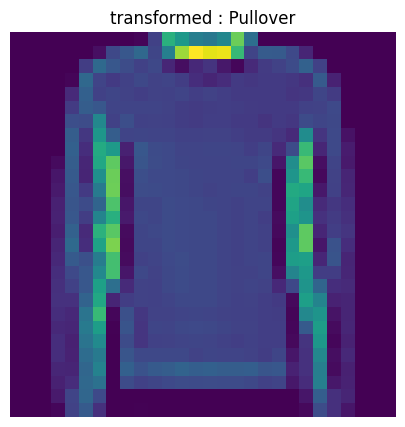

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,5))
plt.imshow(images.squeeze())
plt.title(f"transformed : {train_data.classes[label]}")
plt.axis("off")

## Making the two Model to train the data

In [8]:
from torch import nn

# simple multilayer percepetron (MLP)
class model_linear(nn.Module):
    def __init__(self,
                input:int,       # input size (28*28 = 784 for FashionMNIST)
                hidden_units_1:int,
                hidden_units_2:int,
                output:int):     # output size (10 classes for FashionMNIST)
        super().__init__()
        
        self.flatten = nn.Flatten()  # Flatten the input image
        self.linear_layer_1 = nn.Sequential(
            nn.Linear(in_features=input, out_features=hidden_units_1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units_1, out_features=hidden_units_2)
        )
        self.linear_layer_2 = nn.Sequential(
            nn.Linear(in_features=hidden_units_2, out_features=hidden_units_1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units_1, out_features=hidden_units_2)
        )
        self.linear_layer_3 = nn.Sequential(
            nn.Linear(in_features=hidden_units_2, out_features=hidden_units_1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units_1, out_features=output)
        )

    def forward(self, x):
        return self.linear_layer_3(self.linear_layer_2(self.linear_layer_1(self.flatten(x))))


# Simple CNN
class model_CNN(nn.Module):
    def __init__(self,
                input:int,
                hidden_units:int,
                output:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1), # values we can set ourself in our NN's are called hyperparameter
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size=3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output)
        )
    def forward(self,x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

## Making the Instances of the models

In [9]:
Linear_model = model_linear(input = 28*28,
                           hidden_units_1 = 10,
                           hidden_units_2 = 20,
                           output = len(train_data.classes)).to(device)
CNN_model = model_CNN(input= 1,
                     hidden_units = 8,
                     output = len(train_data.classes)).to(device)

In [10]:
print(len(train_data.classes))

10


## Loss function Optimizer and accuracy_function

In [11]:
loss_fn = nn.CrossEntropyLoss()
model = CNN_model
optimizer_Linear = torch.optim.SGD(model.parameters(),lr=0.01)
optimizer_CNN = torch.optim.Adam(model.parameters(), lr=0.001)
def accuracy_fn(y_pred,y_true):
  correct = torch.eq(y_pred,y_true).sum().item()
  acc = (correct/len(y_true))*100
  return acc

## Fucntionizing the training testing and evaulating

In [12]:
device = "cuda" 
def train_model(model: torch.nn.Module,
                data_loader : torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device : torch.device = device
                ):
  train_loss,train_acc = 0,0
  model.train()

  for batch,(X,y) in enumerate(data_loader):
    X,y = X.to(device),y.to(device)
    y_pred = model(X)

    loss = loss_fn(y_pred,y)
    train_loss += loss
    train_acc += accuracy_fn(y_true = y,y_pred = y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"train_loss: {train_loss:.5f} | train_acc: {train_acc:.2f}%")

def testing_model(model: torch.nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  accuracy_fn,
                  device : torch.device = device):
  test_loss,test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X_test,y_test in data_loader:
      X_test,y_test = X_test.to(device),y_test.to(device)
      test_pred = model(X_test)
      test_loss += loss_fn(test_pred,y_test)
      test_acc += accuracy_fn(y_true = y_test,y_pred = test_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"test_loss: {test_loss:.5f} | test_acc: {test_acc:.2f}%")

def eval_model(model: torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  loss,acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      X,y = X.to(device),y.to(device)
      y_pred = model(X)

      loss = loss_fn(y_pred,y)
      acc += accuracy_fn(y_true = y,y_pred = y_pred.argmax(dim= 1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model name": model.__class__.__name__,
          "loss": loss.item(),
          "acc": acc}

def Train_time(start:float,
               end:float,
               device: torch.device = None):
  total_time = end-start
  print(f"Train time on {device} is {total_time:.3f} seconds")
  return total_time

In [13]:
from pathlib import Path

MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# create model save path


## Training and Testing Phase of Linear model 

In [14]:
from tqdm import tqdm

from timeit import default_timer as timer
train_time_start_model =timer()
epochs = 5
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ...")
  train_model(model = Linear_model,
              data_loader = train_dataloader,
              loss_fn = loss_fn,
              optimizer = optimizer_Linear,
              accuracy_fn = accuracy_fn,
              device = device)
  testing_model(model = Linear_model,
                data_loader = test_dataloader,
                loss_fn = loss_fn,
                accuracy_fn = accuracy_fn,
                device = device)
  train_time_end_model = timer()
  Train_time(start = train_time_start_model,
             end = train_time_end_model,
             device = device)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch: 0 ...
train_loss: 2.31151 | train_acc: 10.02%


 20%|████████████████▊                                                                   | 1/5 [00:13<00:52, 13.12s/it]

test_loss: 2.31151 | test_acc: 10.03%
Train time on cuda is 13.119 seconds
Epoch: 1 ...
train_loss: 2.31151 | train_acc: 10.03%


 40%|█████████████████████████████████▌                                                  | 2/5 [00:29<00:44, 14.82s/it]

test_loss: 2.31148 | test_acc: 10.05%
Train time on cuda is 29.130 seconds
Epoch: 2 ...
train_loss: 2.31151 | train_acc: 10.02%


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:44<00:30, 15.21s/it]

test_loss: 2.31151 | test_acc: 10.04%
Train time on cuda is 44.798 seconds
Epoch: 3 ...
train_loss: 2.31152 | train_acc: 10.03%


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:01<00:15, 15.77s/it]

test_loss: 2.31155 | test_acc: 10.04%
Train time on cuda is 61.444 seconds
Epoch: 4 ...
train_loss: 2.31152 | train_acc: 10.03%


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:16<00:00, 15.39s/it]

test_loss: 2.31156 | test_acc: 10.00%
Train time on cuda is 76.961 seconds


## Training and Testing Phase of CNN model 

In [15]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


from timeit import default_timer as timer
train_time_start_model =timer()
indx = 5
epochs = 20
for i in tqdm(range(indx)):
    for epoch in tqdm(range(epochs)):
      print(f"Epoch: {epoch} ...")
      train_model(model = CNN_model,
                  data_loader = train_dataloader,
                  loss_fn = loss_fn,
                  optimizer = optimizer_CNN,
                  accuracy_fn = accuracy_fn,
                  device = device)
      testing_model(model = CNN_model,
                    data_loader = test_dataloader,
                    loss_fn = loss_fn,
                    accuracy_fn = accuracy_fn,
                    device = device)
        
    # saving and loading model
    MODEL_NAME = f"model_group_{i+1}.pth"
    MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
    torch.save({
        'model_state_dict': CNN_model.state_dict(),
        'optimizer_state_dict': optimizer_CNN.state_dict(),
    }, MODEL_SAVE_PATH)
    # loading model
    checkpoint = torch.load(MODEL_SAVE_PATH)
    CNN_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer_CNN.load_state_dict(checkpoint['optimizer_state_dict'])
train_time_end_model = timer()
Train_time(start = train_time_start_model,
         end = train_time_end_model,
         device = device)


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch: 0 ...
train_loss: 0.58402 | train_acc: 79.41%



  5%|████▏                                                                              | 1/20 [00:13<04:20, 13.72s/it]

test_loss: 0.45635 | test_acc: 83.60%
Epoch: 1 ...
train_loss: 0.38946 | train_acc: 86.22%



 10%|████████▎                                                                          | 2/20 [00:27<04:09, 13.88s/it]

test_loss: 0.38841 | test_acc: 86.26%
Epoch: 2 ...
train_loss: 0.34284 | train_acc: 87.78%



 15%|████████████▍                                                                      | 3/20 [00:40<03:48, 13.44s/it]

test_loss: 0.35389 | test_acc: 87.52%
Epoch: 3 ...
train_loss: 0.31872 | train_acc: 88.55%



 20%|████████████████▌                                                                  | 4/20 [00:54<03:38, 13.64s/it]

test_loss: 0.34066 | test_acc: 88.02%
Epoch: 4 ...
train_loss: 0.30092 | train_acc: 89.26%



 25%|████████████████████▊                                                              | 5/20 [01:08<03:25, 13.68s/it]

test_loss: 0.32063 | test_acc: 88.73%
Epoch: 5 ...
train_loss: 0.29055 | train_acc: 89.70%



 30%|████████████████████████▉                                                          | 6/20 [01:22<03:12, 13.78s/it]

test_loss: 0.31180 | test_acc: 88.87%
Epoch: 6 ...
train_loss: 0.28090 | train_acc: 89.88%



 35%|█████████████████████████████                                                      | 7/20 [01:35<02:56, 13.59s/it]

test_loss: 0.31067 | test_acc: 89.23%
Epoch: 7 ...
train_loss: 0.27419 | train_acc: 90.24%



 40%|█████████████████████████████████▏                                                 | 8/20 [01:49<02:44, 13.67s/it]

test_loss: 0.30917 | test_acc: 89.45%
Epoch: 8 ...
train_loss: 0.26784 | train_acc: 90.33%



 45%|█████████████████████████████████████▎                                             | 9/20 [02:02<02:27, 13.45s/it]

test_loss: 0.30234 | test_acc: 89.31%
Epoch: 9 ...
train_loss: 0.26165 | train_acc: 90.60%



 50%|█████████████████████████████████████████                                         | 10/20 [02:15<02:14, 13.47s/it]

test_loss: 0.29824 | test_acc: 89.21%
Epoch: 10 ...
train_loss: 0.25637 | train_acc: 90.71%



 55%|█████████████████████████████████████████████                                     | 11/20 [02:28<01:59, 13.23s/it]

test_loss: 0.29200 | test_acc: 89.64%
Epoch: 11 ...
train_loss: 0.25229 | train_acc: 90.91%



 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:41<01:45, 13.20s/it]

test_loss: 0.29235 | test_acc: 89.39%
Epoch: 12 ...
train_loss: 0.24940 | train_acc: 91.00%



 65%|█████████████████████████████████████████████████████▎                            | 13/20 [02:54<01:31, 13.12s/it]

test_loss: 0.28439 | test_acc: 90.01%
Epoch: 13 ...
train_loss: 0.24688 | train_acc: 91.07%



 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [03:07<01:18, 13.09s/it]

test_loss: 0.28330 | test_acc: 89.89%
Epoch: 14 ...
train_loss: 0.24258 | train_acc: 91.24%



 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [03:20<01:05, 13.08s/it]

test_loss: 0.28128 | test_acc: 90.36%
Epoch: 15 ...
train_loss: 0.24027 | train_acc: 91.30%



 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:33<00:52, 13.09s/it]

test_loss: 0.28176 | test_acc: 90.13%
Epoch: 16 ...
train_loss: 0.23875 | train_acc: 91.39%



 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [03:47<00:40, 13.38s/it]

test_loss: 0.27903 | test_acc: 90.13%
Epoch: 17 ...
train_loss: 0.23602 | train_acc: 91.45%



 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [04:02<00:27, 13.78s/it]

test_loss: 0.27884 | test_acc: 90.15%
Epoch: 18 ...
train_loss: 0.23479 | train_acc: 91.45%



 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [04:18<00:14, 14.43s/it]

test_loss: 0.27695 | test_acc: 90.43%
Epoch: 19 ...
train_loss: 0.23224 | train_acc: 91.62%



 20%|████████████████▌                                                                  | 1/5 [04:34<18:16, 274.01s/it]

test_loss: 0.28040 | test_acc: 90.12%



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch: 0 ...
train_loss: 0.23023 | train_acc: 91.64%



  5%|████▏                                                                              | 1/20 [00:15<05:03, 15.98s/it]

test_loss: 0.27684 | test_acc: 90.29%
Epoch: 1 ...
train_loss: 0.22923 | train_acc: 91.75%



 10%|████████▎                                                                          | 2/20 [00:29<04:20, 14.46s/it]

test_loss: 0.27879 | test_acc: 90.14%
Epoch: 2 ...
train_loss: 0.22661 | train_acc: 91.86%



 15%|████████████▍                                                                      | 3/20 [00:42<03:56, 13.91s/it]

test_loss: 0.27073 | test_acc: 90.60%
Epoch: 3 ...
train_loss: 0.22792 | train_acc: 91.72%



 20%|████████████████▌                                                                  | 4/20 [00:55<03:38, 13.64s/it]

test_loss: 0.27465 | test_acc: 90.22%
Epoch: 4 ...
train_loss: 0.22398 | train_acc: 92.03%



 25%|████████████████████▊                                                              | 5/20 [01:09<03:22, 13.47s/it]

test_loss: 0.27060 | test_acc: 90.74%
Epoch: 5 ...
train_loss: 0.22457 | train_acc: 91.83%



 30%|████████████████████████▉                                                          | 6/20 [01:23<03:14, 13.88s/it]

test_loss: 0.27063 | test_acc: 90.67%
Epoch: 6 ...
train_loss: 0.22184 | train_acc: 91.97%



 35%|█████████████████████████████                                                      | 7/20 [01:38<03:04, 14.20s/it]

test_loss: 0.26884 | test_acc: 90.48%
Epoch: 7 ...
train_loss: 0.22160 | train_acc: 91.94%



 40%|█████████████████████████████████▏                                                 | 8/20 [01:53<02:52, 14.38s/it]

test_loss: 0.27071 | test_acc: 90.73%
Epoch: 8 ...
train_loss: 0.22115 | train_acc: 91.97%



 45%|█████████████████████████████████████▎                                             | 9/20 [02:07<02:38, 14.38s/it]

test_loss: 0.27388 | test_acc: 90.31%
Epoch: 9 ...
train_loss: 0.21943 | train_acc: 92.00%



 50%|█████████████████████████████████████████                                         | 10/20 [02:21<02:23, 14.34s/it]

test_loss: 0.27080 | test_acc: 90.60%
Epoch: 10 ...
train_loss: 0.21829 | train_acc: 92.10%



 55%|█████████████████████████████████████████████                                     | 11/20 [02:36<02:09, 14.41s/it]

test_loss: 0.27190 | test_acc: 90.32%
Epoch: 11 ...
train_loss: 0.21777 | train_acc: 92.13%



 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:52<01:58, 14.78s/it]

test_loss: 0.26979 | test_acc: 90.37%
Epoch: 12 ...
train_loss: 0.21804 | train_acc: 92.06%



 65%|█████████████████████████████████████████████████████▎                            | 13/20 [03:07<01:45, 15.08s/it]

test_loss: 0.27869 | test_acc: 90.44%
Epoch: 13 ...
train_loss: 0.21919 | train_acc: 92.03%



 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [03:23<01:31, 15.33s/it]

test_loss: 0.26575 | test_acc: 90.53%
Epoch: 14 ...
train_loss: 0.21692 | train_acc: 92.07%



 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [03:38<01:15, 15.09s/it]

test_loss: 0.26477 | test_acc: 90.76%
Epoch: 15 ...
train_loss: 0.21506 | train_acc: 92.20%



 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:52<00:59, 14.82s/it]

test_loss: 0.27060 | test_acc: 90.33%
Epoch: 16 ...
train_loss: 0.21504 | train_acc: 92.20%



 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [04:05<00:42, 14.15s/it]

test_loss: 0.26551 | test_acc: 90.40%
Epoch: 17 ...
train_loss: 0.21541 | train_acc: 92.18%



 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [04:18<00:27, 13.86s/it]

test_loss: 0.26930 | test_acc: 90.44%
Epoch: 18 ...
train_loss: 0.21347 | train_acc: 92.21%



 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [04:31<00:13, 13.53s/it]

test_loss: 0.26730 | test_acc: 90.70%
Epoch: 19 ...
train_loss: 0.21157 | train_acc: 92.30%



 40%|█████████████████████████████████▏                                                 | 2/5 [09:18<14:00, 280.20s/it]

test_loss: 0.26570 | test_acc: 90.63%



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch: 0 ...
train_loss: 0.21336 | train_acc: 92.25%



  5%|████▏                                                                              | 1/20 [00:13<04:10, 13.20s/it]

test_loss: 0.26671 | test_acc: 90.69%
Epoch: 1 ...
train_loss: 0.21054 | train_acc: 92.39%



 10%|████████▎                                                                          | 2/20 [00:26<03:58, 13.25s/it]

test_loss: 0.27093 | test_acc: 90.25%
Epoch: 2 ...
train_loss: 0.21005 | train_acc: 92.34%



 15%|████████████▍                                                                      | 3/20 [00:39<03:46, 13.33s/it]

test_loss: 0.26933 | test_acc: 90.57%
Epoch: 3 ...
train_loss: 0.21080 | train_acc: 92.35%



 20%|████████████████▌                                                                  | 4/20 [00:53<03:33, 13.32s/it]

test_loss: 0.27441 | test_acc: 90.79%
Epoch: 4 ...
train_loss: 0.21146 | train_acc: 92.27%



 25%|████████████████████▊                                                              | 5/20 [01:07<03:24, 13.61s/it]

test_loss: 0.26620 | test_acc: 90.77%
Epoch: 5 ...
train_loss: 0.21010 | train_acc: 92.38%



 30%|████████████████████████▉                                                          | 6/20 [01:20<03:09, 13.52s/it]

test_loss: 0.26454 | test_acc: 90.93%
Epoch: 6 ...
train_loss: 0.20891 | train_acc: 92.34%



 35%|█████████████████████████████                                                      | 7/20 [01:34<02:56, 13.56s/it]

test_loss: 0.26773 | test_acc: 90.66%
Epoch: 7 ...
train_loss: 0.20952 | train_acc: 92.44%



 40%|█████████████████████████████████▏                                                 | 8/20 [01:47<02:39, 13.31s/it]

test_loss: 0.26756 | test_acc: 90.57%
Epoch: 8 ...
train_loss: 0.20706 | train_acc: 92.49%



 45%|█████████████████████████████████████▎                                             | 9/20 [02:00<02:25, 13.25s/it]

test_loss: 0.27147 | test_acc: 90.73%
Epoch: 9 ...
train_loss: 0.20939 | train_acc: 92.50%



 50%|█████████████████████████████████████████                                         | 10/20 [02:13<02:13, 13.38s/it]

test_loss: 0.27175 | test_acc: 90.75%
Epoch: 10 ...
train_loss: 0.20722 | train_acc: 92.47%



 55%|█████████████████████████████████████████████                                     | 11/20 [02:27<02:00, 13.42s/it]

test_loss: 0.26811 | test_acc: 90.74%
Epoch: 11 ...
train_loss: 0.20580 | train_acc: 92.50%



 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:41<01:48, 13.61s/it]

test_loss: 0.27638 | test_acc: 90.66%
Epoch: 12 ...
train_loss: 0.20782 | train_acc: 92.47%



 65%|█████████████████████████████████████████████████████▎                            | 13/20 [02:55<01:35, 13.63s/it]

test_loss: 0.26844 | test_acc: 90.79%
Epoch: 13 ...
train_loss: 0.20541 | train_acc: 92.38%



 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [03:08<01:21, 13.65s/it]

test_loss: 0.26757 | test_acc: 90.41%
Epoch: 14 ...
train_loss: 0.20476 | train_acc: 92.53%



 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [03:23<01:09, 13.95s/it]

test_loss: 0.27006 | test_acc: 90.74%
Epoch: 15 ...
train_loss: 0.20605 | train_acc: 92.43%



 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:36<00:54, 13.74s/it]

test_loss: 0.27092 | test_acc: 90.64%
Epoch: 16 ...
train_loss: 0.20536 | train_acc: 92.43%



 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [03:49<00:40, 13.54s/it]

test_loss: 0.27130 | test_acc: 90.68%
Epoch: 17 ...
train_loss: 0.20398 | train_acc: 92.58%



 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [04:03<00:27, 13.64s/it]

test_loss: 0.27812 | test_acc: 90.64%
Epoch: 18 ...
train_loss: 0.20421 | train_acc: 92.52%



 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [04:16<00:13, 13.53s/it]

test_loss: 0.28192 | test_acc: 90.35%
Epoch: 19 ...
train_loss: 0.20488 | train_acc: 92.54%



 60%|█████████████████████████████████████████████████▊                                 | 3/5 [13:49<09:11, 275.86s/it]

test_loss: 0.26970 | test_acc: 90.57%



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch: 0 ...
train_loss: 0.20412 | train_acc: 92.52%



  5%|████▏                                                                              | 1/20 [00:13<04:07, 13.01s/it]

test_loss: 0.27405 | test_acc: 90.54%
Epoch: 1 ...
train_loss: 0.20418 | train_acc: 92.47%



 10%|████████▎                                                                          | 2/20 [00:26<03:57, 13.22s/it]

test_loss: 0.26281 | test_acc: 90.55%
Epoch: 2 ...
train_loss: 0.20518 | train_acc: 92.49%



 15%|████████████▍                                                                      | 3/20 [00:47<04:48, 16.95s/it]

test_loss: 0.27411 | test_acc: 90.62%
Epoch: 3 ...
train_loss: 0.20414 | train_acc: 92.53%



 20%|████████████████▌                                                                  | 4/20 [01:06<04:43, 17.74s/it]

test_loss: 0.27141 | test_acc: 90.38%
Epoch: 4 ...
train_loss: 0.20223 | train_acc: 92.67%



 25%|████████████████████▊                                                              | 5/20 [01:20<04:05, 16.34s/it]

test_loss: 0.27413 | test_acc: 90.61%
Epoch: 5 ...
train_loss: 0.20246 | train_acc: 92.53%



 30%|████████████████████████▉                                                          | 6/20 [01:35<03:39, 15.70s/it]

test_loss: 0.27041 | test_acc: 90.78%
Epoch: 6 ...
train_loss: 0.20232 | train_acc: 92.54%



 35%|█████████████████████████████                                                      | 7/20 [01:48<03:12, 14.83s/it]

test_loss: 0.27801 | test_acc: 90.61%
Epoch: 7 ...
train_loss: 0.20085 | train_acc: 92.70%



 40%|█████████████████████████████████▏                                                 | 8/20 [02:01<02:50, 14.25s/it]

test_loss: 0.27371 | test_acc: 90.76%
Epoch: 8 ...
train_loss: 0.20195 | train_acc: 92.63%



 45%|█████████████████████████████████████▎                                             | 9/20 [02:13<02:31, 13.80s/it]

test_loss: 0.27572 | test_acc: 90.57%
Epoch: 9 ...
train_loss: 0.20187 | train_acc: 92.56%



 50%|█████████████████████████████████████████                                         | 10/20 [02:26<02:15, 13.54s/it]

test_loss: 0.27579 | test_acc: 90.58%
Epoch: 10 ...
train_loss: 0.20049 | train_acc: 92.67%



 55%|█████████████████████████████████████████████                                     | 11/20 [02:39<02:00, 13.34s/it]

test_loss: 0.27845 | test_acc: 90.56%
Epoch: 11 ...
train_loss: 0.20027 | train_acc: 92.73%



 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:52<01:46, 13.31s/it]

test_loss: 0.27463 | test_acc: 90.85%
Epoch: 12 ...
train_loss: 0.20095 | train_acc: 92.63%



 65%|█████████████████████████████████████████████████████▎                            | 13/20 [03:05<01:32, 13.22s/it]

test_loss: 0.27185 | test_acc: 90.94%
Epoch: 13 ...
train_loss: 0.19986 | train_acc: 92.67%



 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [03:19<01:20, 13.44s/it]

test_loss: 0.27522 | test_acc: 90.58%
Epoch: 14 ...
train_loss: 0.20112 | train_acc: 92.68%



 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [03:33<01:07, 13.52s/it]

test_loss: 0.27152 | test_acc: 90.81%
Epoch: 15 ...
train_loss: 0.20164 | train_acc: 92.56%



 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:48<00:55, 13.79s/it]

test_loss: 0.26909 | test_acc: 90.99%
Epoch: 16 ...
train_loss: 0.19952 | train_acc: 92.76%



 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [04:01<00:41, 13.70s/it]

test_loss: 0.27106 | test_acc: 90.72%
Epoch: 17 ...
train_loss: 0.19829 | train_acc: 92.72%



 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [04:14<00:26, 13.48s/it]

test_loss: 0.27424 | test_acc: 90.66%
Epoch: 18 ...
train_loss: 0.19971 | train_acc: 92.67%



 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [04:27<00:13, 13.19s/it]

test_loss: 0.26620 | test_acc: 91.06%
Epoch: 19 ...
train_loss: 0.19943 | train_acc: 92.71%



 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [18:29<04:37, 277.76s/it]

test_loss: 0.26377 | test_acc: 91.03%



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch: 0 ...
train_loss: 0.19830 | train_acc: 92.75%



  5%|████▏                                                                              | 1/20 [00:12<04:03, 12.81s/it]

test_loss: 0.27487 | test_acc: 90.57%
Epoch: 1 ...
train_loss: 0.19802 | train_acc: 92.77%



 10%|████████▎                                                                          | 2/20 [00:26<03:58, 13.23s/it]

test_loss: 0.27527 | test_acc: 90.78%
Epoch: 2 ...
train_loss: 0.19754 | train_acc: 92.75%



 15%|████████████▍                                                                      | 3/20 [00:39<03:45, 13.27s/it]

test_loss: 0.27292 | test_acc: 91.04%
Epoch: 3 ...
train_loss: 0.19830 | train_acc: 92.79%



 20%|████████████████▌                                                                  | 4/20 [00:52<03:31, 13.20s/it]

test_loss: 0.28213 | test_acc: 90.62%
Epoch: 4 ...
train_loss: 0.19764 | train_acc: 92.78%



 25%|████████████████████▊                                                              | 5/20 [01:06<03:19, 13.31s/it]

test_loss: 0.27012 | test_acc: 90.97%
Epoch: 5 ...
train_loss: 0.19833 | train_acc: 92.78%



 30%|████████████████████████▉                                                          | 6/20 [01:18<03:03, 13.09s/it]

test_loss: 0.27203 | test_acc: 90.75%
Epoch: 6 ...
train_loss: 0.19587 | train_acc: 92.93%



 35%|█████████████████████████████                                                      | 7/20 [01:31<02:49, 13.01s/it]

test_loss: 0.27095 | test_acc: 90.85%
Epoch: 7 ...
train_loss: 0.19588 | train_acc: 92.93%



 40%|█████████████████████████████████▏                                                 | 8/20 [01:46<02:44, 13.67s/it]

test_loss: 0.26667 | test_acc: 90.99%
Epoch: 8 ...
train_loss: 0.19640 | train_acc: 92.84%



 45%|█████████████████████████████████████▎                                             | 9/20 [02:02<02:36, 14.21s/it]

test_loss: 0.28562 | test_acc: 90.68%
Epoch: 9 ...
train_loss: 0.19593 | train_acc: 92.82%



 50%|█████████████████████████████████████████                                         | 10/20 [02:16<02:22, 14.28s/it]

test_loss: 0.27124 | test_acc: 90.99%
Epoch: 10 ...
train_loss: 0.19589 | train_acc: 92.83%



 55%|█████████████████████████████████████████████                                     | 11/20 [02:31<02:08, 14.31s/it]

test_loss: 0.27817 | test_acc: 90.68%
Epoch: 11 ...
train_loss: 0.19588 | train_acc: 92.80%



 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:45<01:55, 14.41s/it]

test_loss: 0.27057 | test_acc: 90.86%
Epoch: 12 ...
train_loss: 0.19668 | train_acc: 92.83%



 65%|█████████████████████████████████████████████████████▎                            | 13/20 [03:00<01:41, 14.46s/it]

test_loss: 0.27195 | test_acc: 90.77%
Epoch: 13 ...
train_loss: 0.19512 | train_acc: 92.83%



 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [03:13<01:24, 14.01s/it]

test_loss: 0.26760 | test_acc: 90.96%
Epoch: 14 ...
train_loss: 0.19382 | train_acc: 92.99%



 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [03:26<01:09, 13.86s/it]

test_loss: 0.27172 | test_acc: 90.96%
Epoch: 15 ...
train_loss: 0.19516 | train_acc: 92.79%



 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:40<00:55, 13.85s/it]

test_loss: 0.26803 | test_acc: 90.95%
Epoch: 16 ...
train_loss: 0.19375 | train_acc: 92.91%



 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [03:55<00:42, 14.15s/it]

test_loss: 0.27291 | test_acc: 90.62%
Epoch: 17 ...
train_loss: 0.19507 | train_acc: 92.83%



 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [04:08<00:27, 13.96s/it]

test_loss: 0.27807 | test_acc: 90.54%
Epoch: 18 ...
train_loss: 0.19489 | train_acc: 92.89%



 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [04:22<00:13, 13.78s/it]

test_loss: 0.27379 | test_acc: 90.47%
Epoch: 19 ...
train_loss: 0.19519 | train_acc: 92.87%



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [23:05<00:00, 277.20s/it]

test_loss: 0.27200 | test_acc: 90.77%
Train time on cuda is 1386.006 seconds


1386.0064584999998

## Evaluating the models  

In [16]:
linear_model_result = eval_model(model = Linear_model,
          data_loader = test_dataloader,
          loss = loss_fn,
          accuracy_fn = accuracy_fn,
          device = device),
CNN_model_results = eval_model(model = CNN_model,
          data_loader = test_dataloader,
          loss = loss_fn,
          accuracy_fn = accuracy_fn,
          device = device)
linear_model_result,CNN_model_results

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 82.26it/s]


(({'model name': 'model_linear',
   'loss': 0.007374871522188187,
   'acc': 10.043929712460065},),
 {'model name': 'model_CNN',
  'loss': 0.0007621188415214419,
  'acc': 90.75479233226837})

## Results

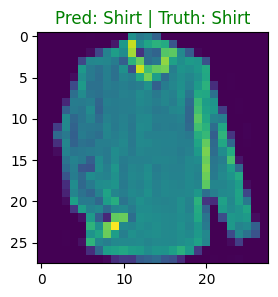

In [17]:
# Testing random testing
def testing_function(model:torch.nn.Module,
                    data:list,
                    device: torch.device = device):
    pred_probs = []
    model.to(device)
    with torch.inference_mode():
        for sample in data:
          sample = torch.unsqueeze(sample,dim=0).to(device)
          pred_logit = model(sample)
          pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
          pred_probs.append(pred_prob.cpu())
        return torch.stack(pred_probs)
test_sample = []
test_labels =[]
for sample,label in random.sample(list(test_data),k=9):
    test_sample.append(sample)
    test_labels.append(label)

# mkaing prediction
test_pred = testing_function(model=CNN_model,
                            data=test_sample)
test_class = test_pred.argmax(dim=1)

num = 3
plt.figure(figsize=(3,3))
plt.imshow(test_sample[num].squeeze())
pred_label = train_data.classes[test_class[num]]
true_label = train_data.classes[test_labels[num]]

title_text = f"Pred: {pred_label} | Truth: {true_label}"

# Set title color based on prediction accuracy
if pred_label == true_label:
    plt.title(title_text, fontsize=12, color="green")  # Green for correct predictions
else:
    plt.title(title_text, fontsize=12, color="red")    # Red for incorrect predictions

# Hide axis for clarity
# plt.axis('off')
plt.show()